In [1396]:
import numpy as np
import pandas as pd
from pandas.api.types import is_object_dtype
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from xgboost import XGBRegressor
import matplotlib.gridspec as gridspec
import matplotlib.pylab as pl

In [1397]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.options.display.float_format = '{:.2f}'.format

In [1398]:
train=pd.read_csv('/home/ivan_pronin/IT/kaggle/house-prices-advanced-regression-techniques/train.csv')
# train=pd.read_csv('C:/Users/julal/IT/kaggle/house-prices-advanced-regression-techniques/train.csv')
test=pd.read_csv('/home/ivan_pronin/IT/kaggle/house-prices-advanced-regression-techniques/test.csv')
# test=pd.read_csv('C:/Users/julal/IT/kaggle/house-prices-advanced-regression-techniques/test.csv')
data_description='/home/ivan_pronin/IT/kaggle/house-prices-advanced-regression-techniques/sample_submission.csv'
# data_descriprion='C:/Users/julal/IT/kaggle/house-prices-advanced-regression-techniques/data_description.txt'

In [1399]:
# def yearsafterremod(row):
#     if row['YearRemodAdd'] == row['YearBuilt'] and (row['YrSold']-row['YearRemodAdd'])>=0:
#         return row['YrSold']-row['YearRemodAdd']
#     elif row['YearRemodAdd'] != row['YearBuilt'] and (row['YrSold']-row['YearBuilt'])>=0:
#         return row['YrSold']-row['YearBuilt']
#     else:
#         return 0

# train['YearsAfterRemod']=train.apply(yearsafterremod, axis=1)

In [1400]:
train=train.drop(columns=['Alley', 'PoolQC','Fence', 'MiscFeature','GarageArea', 'MSSubClass'])
test=test.drop(columns=['Alley', 'PoolQC','Fence', 'MiscFeature','GarageArea', 'MSSubClass'])

In [1401]:
print(train.shape)
print(test.shape)

(1460, 75)
(1459, 74)


In [1402]:
nonnumeric_features=[]
for col in train.columns:
    if is_object_dtype(train[col]):
        nonnumeric_features.append(col)

In [1403]:
train[nonnumeric_features].describe()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,588,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,1460,1460
unique,5,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,3,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,9,6
top,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,WD,Normal
freq,1151,1454,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,445,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,1267,1198


In [1404]:
train.loc[:, ~train.columns.isin(nonnumeric_features)].describe()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.00,1201.00,1460.00,1460.00,1460.00,1460.00,1460.00,1452.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1379.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00
mean,730.50,70.05,10516.83,6.10,5.58,1971.27,1984.87,103.69,443.64,46.55,567.24,1057.43,1162.63,346.99,5.84,1515.46,0.43,0.06,1.57,0.38,2.87,1.05,6.52,0.61,1978.51,1.77,94.24,46.66,21.95,3.41,15.06,2.76,43.49,6.32,2007.82,180921.20
std,421.61,24.28,9981.26,1.38,1.11,30.20,20.65,181.07,456.10,161.32,441.87,438.71,386.59,436.53,48.62,525.48,0.52,0.24,0.55,0.50,0.82,0.22,1.63,0.64,24.69,0.75,125.34,66.26,61.12,29.32,55.76,40.18,496.12,2.70,1.33,79442.50
min,1.00,21.00,1300.00,1.00,1.00,1872.00,1950.00,0.00,0.00,0.00,0.00,0.00,334.00,0.00,0.00,334.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,1900.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2006.00,34900.00
25%,365.75,59.00,7553.50,5.00,5.00,1954.00,1967.00,0.00,0.00,0.00,223.00,795.75,882.00,0.00,0.00,1129.50,0.00,0.00,1.00,0.00,2.00,1.00,5.00,0.00,1961.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,2007.00,129975.00
50%,730.50,69.00,9478.50,6.00,5.00,1973.00,1994.00,0.00,383.50,0.00,477.50,991.50,1087.00,0.00,0.00,1464.00,0.00,0.00,2.00,0.00,3.00,1.00,6.00,1.00,1980.00,2.00,0.00,25.00,0.00,0.00,0.00,0.00,0.00,6.00,2008.00,163000.00
75%,1095.25,80.00,11601.50,7.00,6.00,2000.00,2004.00,166.00,712.25,0.00,808.00,1298.25,1391.25,728.00,0.00,1776.75,1.00,0.00,2.00,1.00,3.00,1.00,7.00,1.00,2002.00,2.00,168.00,68.00,0.00,0.00,0.00,0.00,0.00,8.00,2009.00,214000.00
max,1460.00,313.00,215245.00,10.00,9.00,2010.00,2010.00,1600.00,5644.00,1474.00,2336.00,6110.00,4692.00,2065.00,572.00,5642.00,3.00,2.00,3.00,2.00,8.00,3.00,14.00,3.00,2010.00,4.00,857.00,547.00,552.00,508.00,480.00,738.00,15500.00,12.00,2010.00,755000.00


In [1405]:
train

,Id,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,RL,65.00,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.00,RFn,2,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,RL,80.00,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.00,RFn,2,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,RL,68.00,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.00,RFn,2,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,RL,60.00,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.00,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.00,Unf,3,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,RL,84.00,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.00,RFn,3,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,RL,62.00,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,NaN,0.00,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.00,RFn,2,TA,TA,Y,0,40,0,0,0,0,0,8,2007,WD,Normal,175000
1456,1457,RL,85.00,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.00,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.00,Unf,2,TA,TA,Y,349,0,0,0,0,0,0,2,2010,WD,Normal,210000
1457,1458,RL,66.00,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,NaN,0.00,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.00,RFn,1,TA,TA,Y,0,60,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,1459,RL,68.00,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,NaN,0.00,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,NaN,Attchd,1950.00,Unf,1,TA,TA,Y,366,0,112,0,0,0,0,4,2010,WD,Normal,142125


In [1406]:
with open(data_description, 'r') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
#         if any(feature in line for feature in ['LotFrontage', 'MasVnrType', 'FireplaceQu']):
        if 'HalfBath' in line:
            print(line)
            for j in range(i+1, min(i+10, len(lines))):
                print(lines[j])

In [1407]:
nonnumeric_features.extend([
                            'Id',
                            'BsmtFullBath',
                            ])

In [1408]:
train[nonnumeric_features]=train[nonnumeric_features].astype('category')
test[nonnumeric_features]=test[nonnumeric_features].astype('category')

In [1409]:
numeric_features=[]
for col in train.columns:
    if is_numeric_dtype(train[col]):
        numeric_features.append(col)
    else:
        pass
print(numeric_features)

['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


In [1410]:
zero_data_set_sum_train=train.isnull().sum()
zero_data_set_percentage_train=train.isnull().sum()/train.shape[0]*100
zero_data_set_train=pd.DataFrame({'sum':zero_data_set_sum_train, 'percentage': zero_data_set_percentage_train})
zero=zero_data_set_train.loc[zero_data_set_train['sum']>0]

In [1411]:
zero

,sum,percentage
LotFrontage,259,17.74
MasVnrType,872,59.73
MasVnrArea,8,0.55
BsmtQual,37,2.53
BsmtCond,37,2.53
BsmtExposure,38,2.60
BsmtFinType1,37,2.53
BsmtFinType2,38,2.60
Electrical,1,0.07
FireplaceQu,690,47.26


In [1412]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='constant', fill_value=-999)
imputer2= SimpleImputer(strategy='constant', fill_value=-999)
imputer3= SimpleImputer(strategy='most_frequent')

In [1413]:
column_to_impute_train=[]
for i in range(len(zero.index)):
    column_to_impute_train.append(zero.index[i])
for col in column_to_impute_train:
    if col in numeric_features:
        imputed_column = imputer.fit_transform(train[[col]])
        train[[col]] = imputed_column
    else:
        imputed_column = imputer2.fit_transform(train[[col]])
        train[[col]] = imputed_column

In [1414]:
zero_data_set_sum_test=test.isnull().sum()
zero_data_set_percentage_test=test.isnull().sum()/test.shape[0]*100
zero_data_set_test=pd.DataFrame({'sum':zero_data_set_sum_test, 'percentage': zero_data_set_percentage_test})
zero2=zero_data_set_test.loc[zero_data_set_test['sum']>0]
zero2

,sum,percentage
MSZoning,4,0.27
LotFrontage,227,15.56
Utilities,2,0.14
Exterior1st,1,0.07
Exterior2nd,1,0.07
MasVnrType,894,61.27
MasVnrArea,15,1.03
BsmtQual,44,3.02
BsmtCond,45,3.08
BsmtExposure,44,3.02


In [1415]:
column_to_impute_test_as_train=[]
column_to_impute_test_only=[]
for i in range(len(zero2.index)):
    if zero2.index[i] in zero.index:
        column_to_impute_test_as_train.append(zero2.index[i])
    else:
        column_to_impute_test_only.append(zero2.index[i])
for col in column_to_impute_test_as_train:
    if col in numeric_features:
        imputed_column = imputer.fit_transform(test[[col]])
        test[[col]] = imputed_column
    else:
        imputed_column = imputer2.fit_transform(test[[col]])
        test[[col]] = imputed_column
for col in column_to_impute_test_only:
    if col in numeric_features:
        imputed_column = imputer.fit_transform(test[[col]])
        test[[col]] = imputed_column
    else:
        imputed_column = imputer3.fit_transform(test[[col]])
        test[[col]] = imputed_column

In [1416]:
test['BsmtFullBath']=test['BsmtFullBath'].astype(int)

In [1417]:
# data_list=['Neighborhood', 'BsmtQual', 'KitchenQual', 'FireplaceQu', 'ExterQual', 'GarageType', 'CentralAir', 'BsmtExposure']
# for col in data_list:
#     train[col]=train[col].astype(str)
# fig,ax=pl.subplots(1,8, figsize=(30,10))
# count=0
# for col in data_list:
#     ax[count].hist(train[col])
#     ax[count].set_xlabel(col)
#     count+=1
# plt.show()

array([[<Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>,
        <Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'YearRemodAdd'}>],
       [<Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>,
        <Axes: title={'center': 'TotalBsmtSF'}>,
        <Axes: title={'center': '1stFlrSF'}>],
       [<Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtHalfBath'}>,
        <Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>],
       [<Axes: title={'center': 'BedroomAbvGr'}>,
        <Axes: title={'center': 'KitchenAbvGr'}>,
        <Axes: title={'center': 'TotR

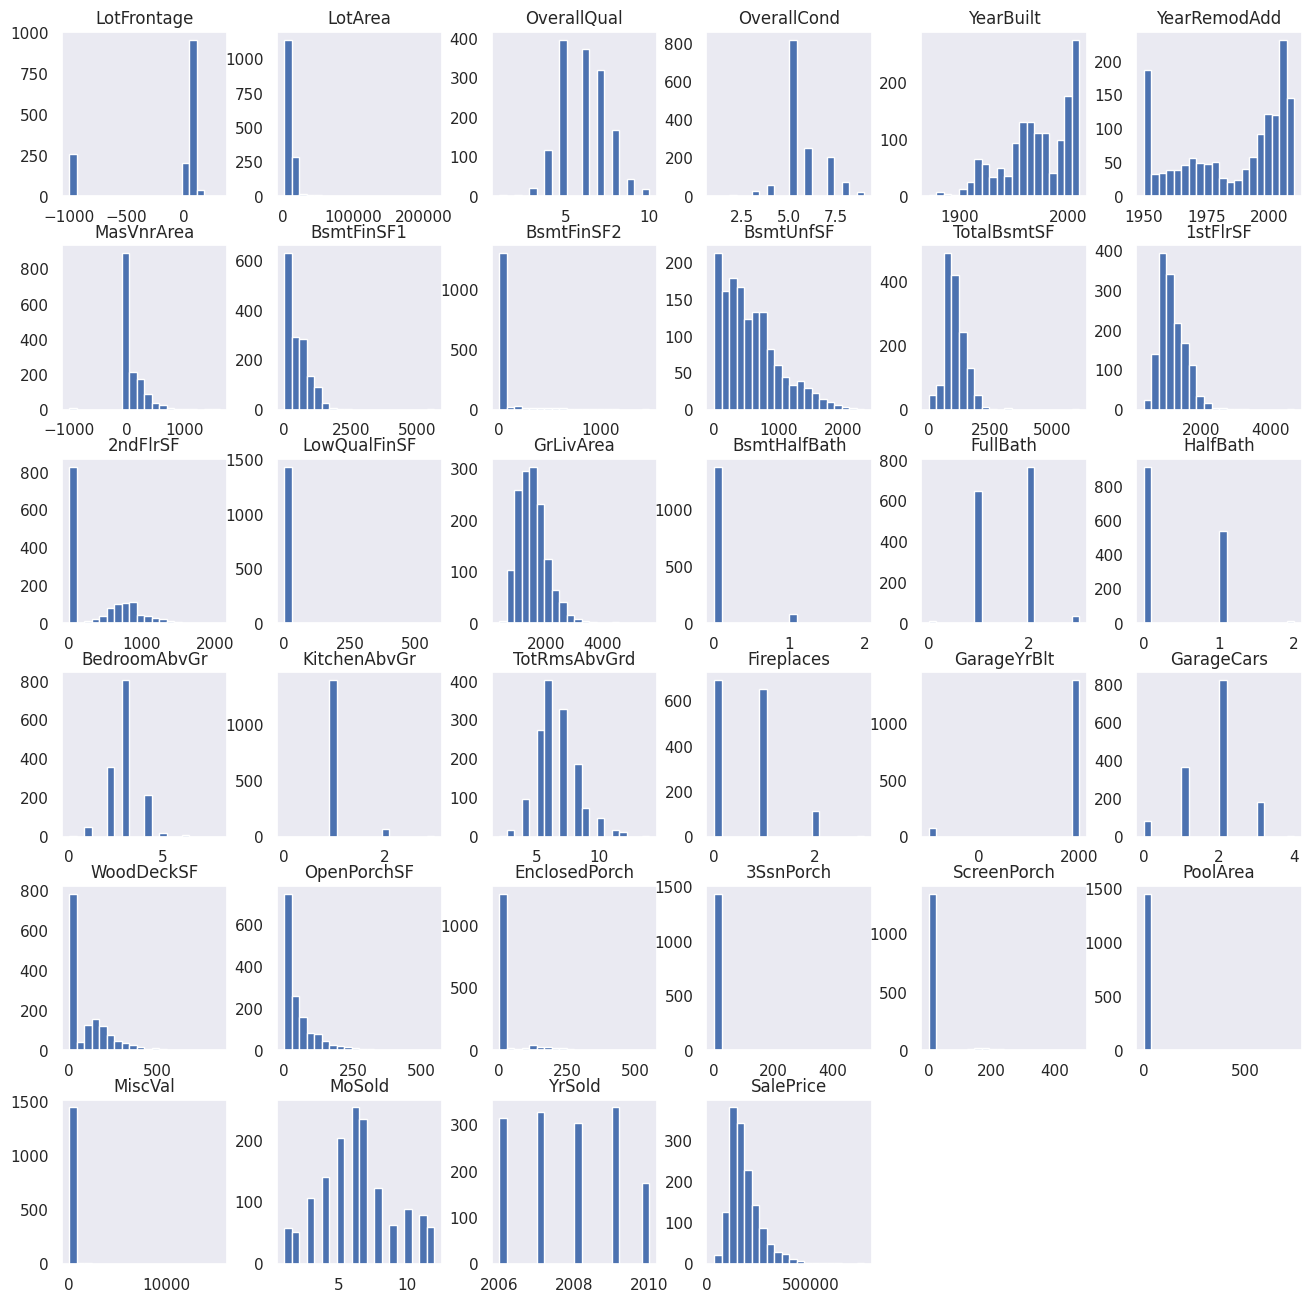

In [1418]:
train.hist(figsize=(16,16), bins=20, grid=False)

In [1419]:
train[numeric_features].columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [1420]:
train.loc[train['PoolArea']>0, 'PoolArea']=1
test.loc[test['PoolArea']>0, 'PoolArea']=1
# train.loc[train['LowQualFinSF']>0, 'LowQualFinSF']=1
# test.loc[test['LowQualFinSF']>0, 'LowQualFinSF']=1

In [1421]:
# for col in numeric_features:
#     print(train[col].value_counts())

In [1422]:
train[numeric_features].columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [1423]:
with open(data_description, 'r') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
#         if any(feature in line for feature in ['LotFrontage', 'MasVnrType', 'FireplaceQu']):
        if 'YearBuilt' in line:
            print(line)
            for j in range(i+1, min(i+10, len(lines))):
                print(lines[j])

In [1424]:
train[nonnumeric_features]

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition,Id,BsmtFullBath
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,-999,Attchd,RFn,TA,TA,Y,WD,Normal,1,1
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,-999,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal,2,0
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal,3,1
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,-999,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml,4,1
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,-999,TA,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal,1456,0
1456,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,Plywood,Plywood,Stone,TA,TA,CBlock,Gd,TA,No,ALQ,Rec,GasA,TA,Y,SBrkr,TA,Min1,TA,Attchd,Unf,TA,TA,Y,WD,Normal,1457,1
1457,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,CemntBd,CmentBd,-999,Ex,Gd,Stone,TA,Gd,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,WD,Normal,1458,0
1458,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,MetalSd,MetalSd,-999,TA,TA,CBlock,TA,TA,Mn,GLQ,Rec,GasA,Gd,Y,FuseA,Gd,Typ,-999,Attchd,Unf,TA,TA,Y,WD,Normal,1459,1


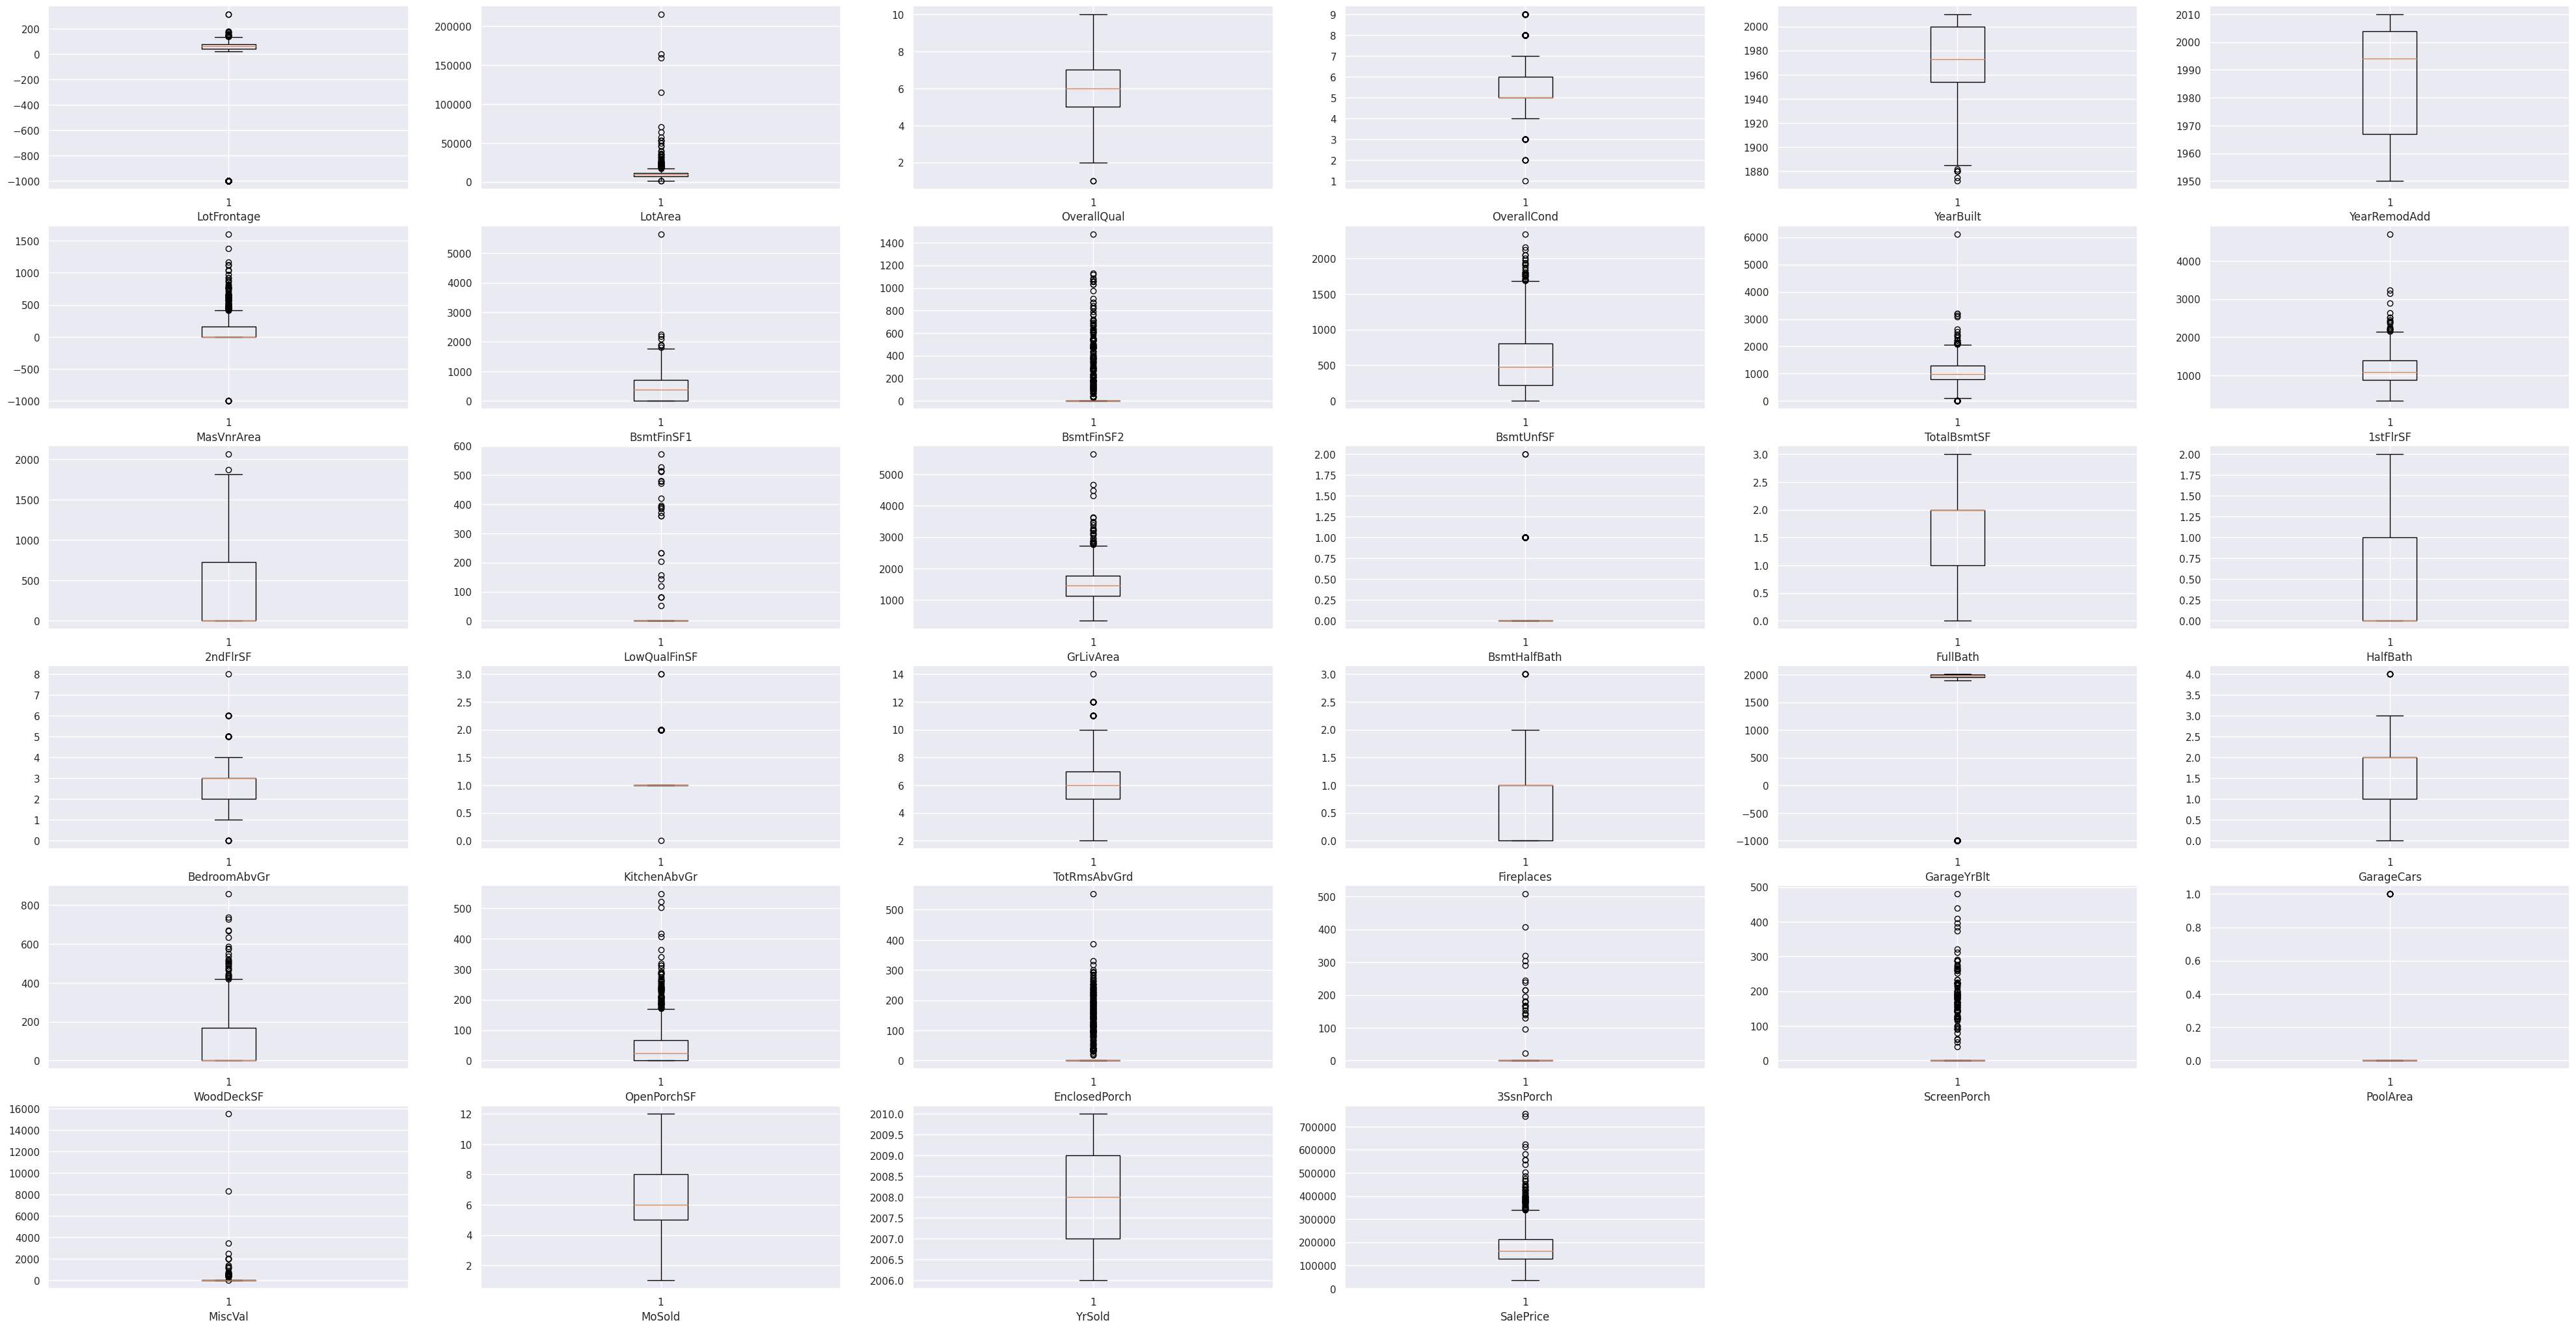

In [1425]:
gs = gridspec.GridSpec(7, 6)
plt.figure(figsize=(50,30))

column=0
for i in range(7):
    column_curr=column
    for z in range(6):
        if column_curr <len(numeric_features):
            ax = plt.subplot(gs[i, z])
            ax.boxplot(train[train[numeric_features].columns[column_curr]])
            ax.set_xlabel(train[numeric_features].columns[column_curr])
            column_curr+=1
            column=column_curr
column+=7

plt.show()

In [1426]:
smoth_columns=[
               'LotArea',
            #    'ScreenPorch'
               ]

In [1427]:
for col in smoth_columns:
    q1 = np.percentile(train[col], 25)
    q3 = np.percentile(train[col], 75)
    iqr = q3 - q1
    lower_bound = q1 - 2 * iqr
    upper_bound = q3 + 2 * iqr
    train.loc[(train[col] > upper_bound) | (train[col] < lower_bound), col] = np.nan
    train[col].interpolate(method='polynomial', order=5, inplace=True)

In [1428]:
for col in smoth_columns:
    q1 = np.percentile(test[col], 25)
    q3 = np.percentile(test[col], 75)
    iqr = q3 - q1
    lower_bound = q1 - 2 * iqr
    upper_bound = q3 + 2 * iqr
    test.loc[(test[col] > upper_bound) | (test[col] < lower_bound), col] = np.nan
    test[col].interpolate(method='polynomial', order=5, inplace=True)

In [1429]:
train[numeric_features].columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

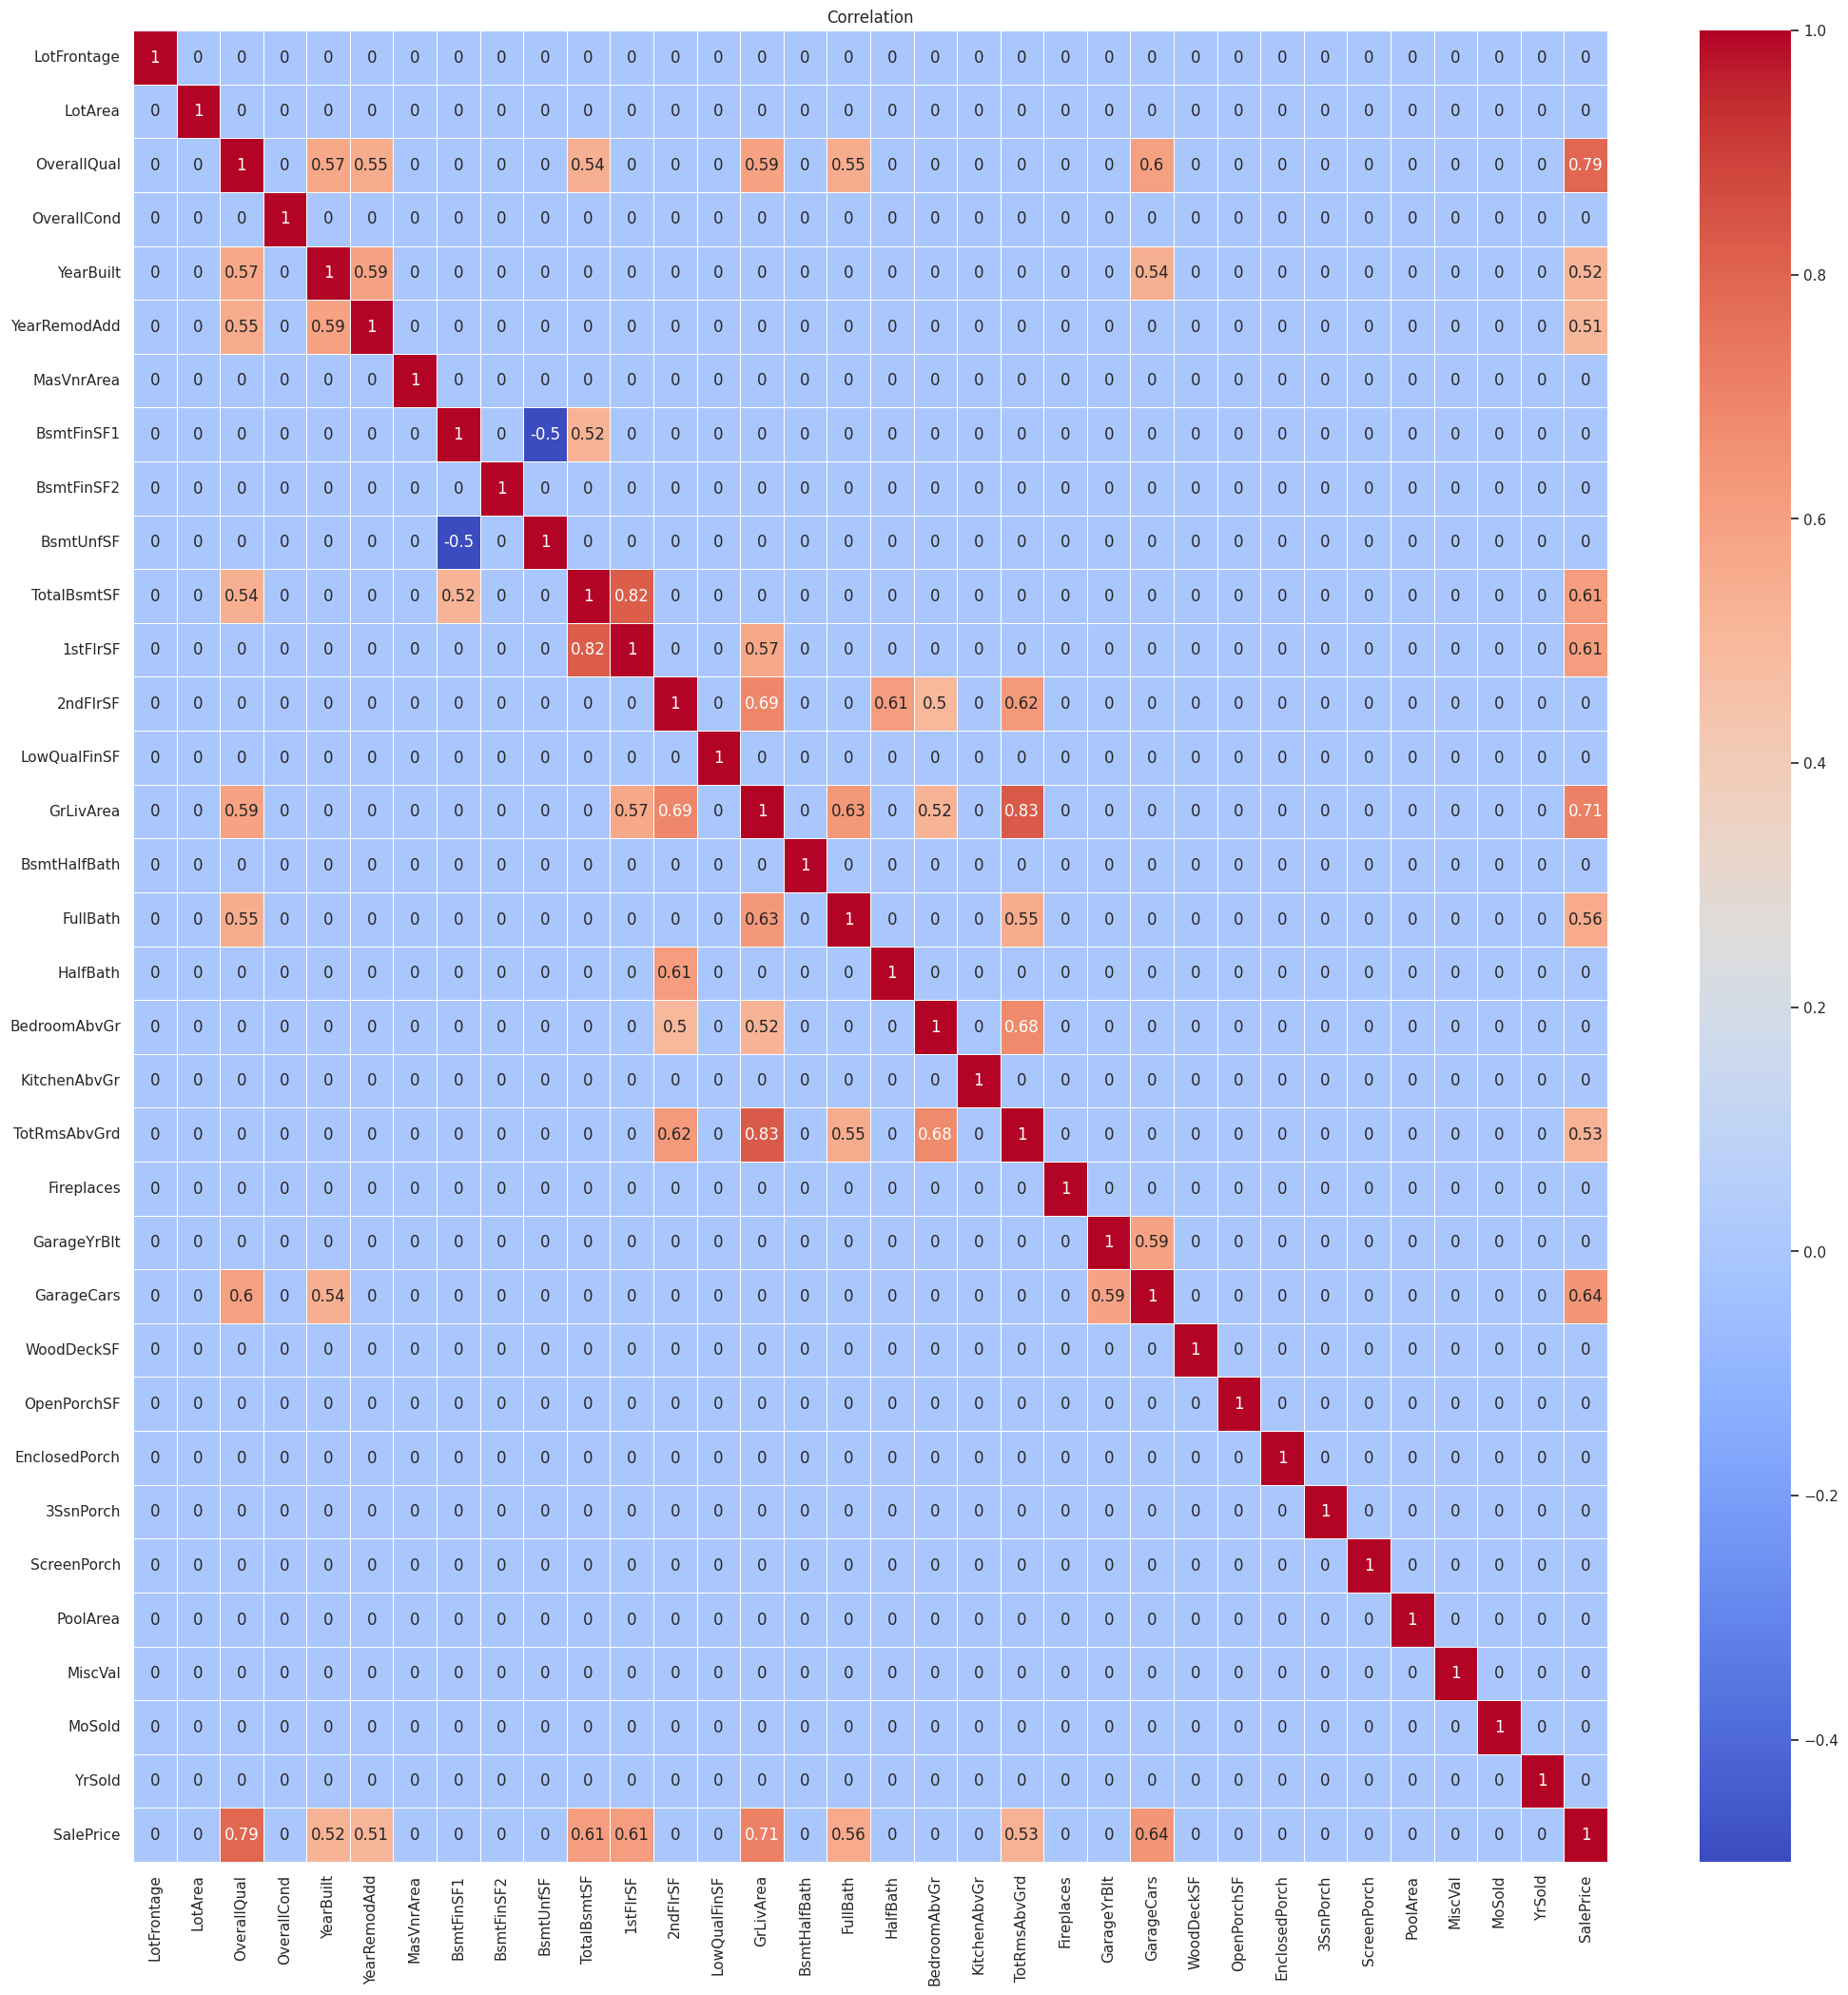

In [1430]:
plt.figure(figsize=(25,25))

sns.set(font_scale=1)

corr_matrix=train[numeric_features].corr()
corr_matrix=np.round(corr_matrix,2)
corr_matrix[np.abs(corr_matrix)<0.5]=0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation')
plt.show()

In [1431]:
y=train['SalePrice'].to_numpy()
train.drop(columns=['SalePrice'], inplace=True)

In [1432]:
numeric_features.remove('SalePrice')

In [1433]:
for col in numeric_features:
    train[col]=train[col].astype(str)
    test[col]=test[col].astype(str)

In [1434]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=2)

In [1435]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1168, 74), (1168,), (292, 74), (292,))

In [1436]:
import catboost as cb
train_dataset = cb.Pool(train,y,
                        cat_features=nonnumeric_features
)                                                     
# test_dataset = cb.Pool(x_test,y_test,          
#                        cat_features=nonnumeric_features)

In [1437]:
CAT=cb.CatBoostRegressor(metric_period=100,
                        #  eval_metric='RMSE',
                         task_type='GPU',
                         iterations=1600, 
                         learning_rate=0.02,
                        #  early_stopping_rounds = 50,
                         depth=8,
                         
                         
                        )
history=CAT.fit(train_dataset,
        # eval_set=test_dataset
)

0:	learn: 78353.7522727	total: 95.9ms	remaining: 2m 33s
100:	learn: 32200.5747778	total: 9.73s	remaining: 2m 24s
200:	learn: 24498.7910474	total: 18.4s	remaining: 2m 8s
300:	learn: 21727.8597127	total: 26.7s	remaining: 1m 55s
400:	learn: 20030.1610605	total: 35.7s	remaining: 1m 46s
500:	learn: 18921.2777465	total: 44.7s	remaining: 1m 38s
600:	learn: 18208.0279654	total: 53.5s	remaining: 1m 28s
700:	learn: 17778.3571622	total: 1m 2s	remaining: 1m 20s
800:	learn: 17433.2735149	total: 1m 13s	remaining: 1m 13s
900:	learn: 17064.9597685	total: 1m 23s	remaining: 1m 4s
1000:	learn: 16656.9314913	total: 1m 32s	remaining: 55.1s
1100:	learn: 16337.6330205	total: 1m 41s	remaining: 46s
1200:	learn: 15918.6390332	total: 1m 51s	remaining: 36.9s
1300:	learn: 15581.1765325	total: 2m	remaining: 27.7s
1400:	learn: 15320.7989262	total: 2m 10s	remaining: 18.5s
1500:	learn: 15029.3596637	total: 2m 19s	remaining: 9.22s
1599:	learn: 14826.7668680	total: 2m 28s	remaining: 0us


In [1268]:
feature_importance = CAT.get_feature_importance(train_dataset)
feature_names = train.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

feature_importance_df

,Feature,Importance
44,GrLivArea,23.15
15,OverallQual,20.06
36,TotalBsmtSF,8.09
41,1stFlrSF,5.90
10,Neighborhood,4.67
59,GarageCars,4.41
32,BsmtFinSF1,3.28
55,FireplaceQu,2.54
28,BsmtQual,2.25
51,KitchenQual,2.02


In [45]:
dict1={'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 10000,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'od_pval': 0,
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': True,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': True,
 'od_wait': 50,
 'random_seed': 0,
 'depth': 8,
 'ctr_target_border_count': 1,
 'posterior_sampling': False,
 'has_time': False,
 'store_all_simple_ctr': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.03999999910593033,
 'score_function': 'Cosine',
 'task_type': 'CPU',
 'leaf_estimation_iterations': 1,
 'bootstrap_type': 'MVS',
 'max_leaves': 256,
 'permutation_count': 4}

dict2={'nan_mode': 'Min',
 'gpu_ram_part': 0.95,
 'eval_metric': 'RMSE',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'FeatureFreq:CtrBorderCount=15:CtrBorderType=Median:Prior=0/1'],
 'iterations': 10000,
 'fold_permutation_block': 64,
 'leaf_estimation_method': 'Newton',
 'observations_to_bootstrap': 'TestOnly',
 'od_pval': 0,
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Ordered',
 'ctr_history_unit': 'Sample',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'devices': '-1',
 'eval_fraction': 0,
 'pinned_memory_bytes': '104857600',
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': True,
 'gpu_cat_features_storage': 'GpuRam',
 'fold_size_loss_normalization': False,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'FeatureFreq:CtrBorderCount=15:CtrBorderType=MinEntropy:Prior=0/1'],
 'pool_metainfo_options': {'tags': {}},
 'use_best_model': True,
 'meta_l2_frequency': 0,
 'od_wait': 50,
 'random_seed': 0,
 'depth': 8,
 'ctr_target_border_count': 1,
 'has_time': False,
 'fold_len_multiplier': 2,
 'border_count': 128,
 'min_fold_size': 100,
 'data_partition': 'FeatureParallel',
 'bagging_temperature': 1,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'min_data_in_leaf': 1,
 'add_ridge_penalty_to_loss_function': False,
 'loss_function': 'RMSE',
 'learning_rate': 0.03999999910593033,
 'meta_l2_exponent': 1,
 'score_function': 'Cosine',
 'task_type': 'GPU',
 'leaf_estimation_iterations': 1,
 'bootstrap_type': 'Bayesian',
 'max_leaves': 256,
 'permutation_count': 4}

diff1={}
diff2={}

for key in dict1:
    if key not in dict2 or dict1[key]!=dict2[key]:
        diff1.update({key:dict1[key]})
for key in dict2:
    if key not in dict1 or dict2[key]!=dict1[key]:
        diff2.update({key:dict2[key]})

df1=pd.DataFrame(diff1).transpose().reset_index()
df1=df1.set_axis(['param','first', 'second'], axis=1)
def choice(row):
    if row['first']!=row['second']:
        return row['first']+row['second']
    else:
        return row['second']
df1['CPU']=df1.apply(choice, axis=1)
df1.drop(columns=['first', 'second'], inplace=True)
df2=pd.DataFrame(diff2).transpose().reset_index()
df2=df2.set_axis(['param','first', 'second'], axis=1)
def choice(row):
    if row['first']!=row['second']:
        return row['first']+row['second']
    else:
        return row['second']
df2['GPU']=df2.apply(choice, axis=1)
df2.drop(columns=['first', 'second'], inplace=True)


In [46]:
df = df1.merge(df2, left_on='param',
                  right_on='param', how='outer')
df

,param,CPU,GPU
0,combinations_ctr,Borders:CtrBorderCount=15:CtrBorderType=Unifor...,Borders:CtrBorderCount=15:CtrBorderType=Unifor...
1,sampling_frequency,PerTree,NaN
2,fold_permutation_block,0,64
3,boosting_type,Plain,Ordered
4,model_shrink_mode,Constant,NaN
5,ctr_leaf_count_limit,18446744073709551615,NaN
6,simple_ctr,Borders:CtrBorderCount=15:CtrBorderType=Unifor...,Borders:CtrBorderCount=15:CtrBorderType=Unifor...
7,subsample,0.80,NaN
8,posterior_sampling,False,NaN
9,store_all_simple_ctr,False,NaN


In [47]:
# CAT_importance_features=[]
# for index, row in feature_importance_df.iterrows():
#     if row['Importance']>1 and row['Feature'] not in nonnumeric_features:
#         CAT_importance_features.append(row['Feature'])

In [48]:
# CAT_importance_features

In [1493]:
y_pred_train=CAT.predict(train)
y_pred_test=CAT.predict(test)

In [1439]:
numeric_features.append('Y_pred')

In [1440]:
nonnumeric_features.remove('Id')

In [1763]:
test.drop(columns=['SalePrice'], inplace=True)

In [1786]:
train2 = train.copy()
test2 = test.copy()
y2 = y.copy()

In [1787]:
train2['Y_pred']=y_pred_train
test2['Y_pred']=y_pred_test

In [1788]:
train2.drop(columns=['Id'], inplace=True)
test2.drop(columns=['Id'], inplace=True)
train2=train2.astype(object)
test2=test2.astype(object)

In [1789]:
def change(x):
      if x==-999:
            return 'not_filled'
      else:
            return x

for feature in nonnumeric_features:
      train2[feature]=train2[feature].apply(change)
      test2[feature]=test2[feature].apply(change)

In [1790]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for feature in nonnumeric_features:
        train2[feature] = le.fit_transform(train2[feature])
        test2[feature] = le.transform(test2[feature])

In [1791]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler2 = StandardScaler()
scaler3 = StandardScaler()
# scaler = MinMaxScaler()

train2= scaler.fit_transform(train2).astype(float)
test2 = scaler2.fit_transform(test2).astype(float)
y2 = scaler3.fit_transform(y2.reshape(-1, 1))

In [1792]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, Y_train, Y_test = train_test_split(train2, y2, test_size=0.2, random_state=2)

In [1793]:
# x_train2 = X_train.copy()
# x_test2 = X_test.copy()
# y_train2=Y_train.copy()
# y_test2=Y_test.copy()
x_train2 = train2.copy()
x_test2 = test2.copy()
y_train2=y2.copy()

In [1794]:
# x_train2.shape, y_train2.shape, x_test2.shape, y_test2.shape

In [1795]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

MLP = Sequential([
        Dense(5, input_shape=(x_train2.shape[1],)),
        Dense(1)
    ])

# MLP.summary()

MLP.compile(optimizer='adam', loss='mse')

In [1796]:
# early_stopping = EarlyStopping(monitor='loss', patience=50)
history=MLP.fit(x_train2,y_train2, 
                epochs=140, 
                # validation_data=(x_test2, y_test2), 
                # callbacks=[early_stopping],
                verbose=False
                )

In [1797]:
y_pred_mlp_train=MLP.predict(x_train2)
y_pred_mlp_test=MLP.predict(x_test2)

46/46 [==============================] - 0s 988us/step


In [1798]:
from sklearn.metrics import mean_squared_error
# mse_test_mlp=mean_squared_error(y_test2, y_pred_mlp_test)
mse_train_mlp=history.history["loss"][-1]
quantity_of_epochs = history.epoch[-1] + 1

# print(f'MSE on test is {mse_test_mlp:.05f}')
print(f'MSE on train is {mse_train_mlp:.05f}')
print(f'The best result stopped on {quantity_of_epochs}')
# print(f'MSE on test_data is more/less train_data by {(mse_test_mlp/mse_train_mlp-1):.03f}')

MSE on train is 0.04723
The best result stopped on 140


In [1799]:
y_pred_test2=scaler3.inverse_transform(y_pred_mlp_test.reshape(-1, 1))
# y_test_after=scaler3.inverse_transform(y_test2.reshape(-1, 1))

In [1800]:
# print(f'rmse after first launch of MLP is {np.sqrt(np.sum((np.squeeze(y_test_after)-np.squeeze(y_pred_test2))**2)/len(y_pred_test2))}')

In [1801]:
# print(f'rmse before MLP cycle is {np.sqrt(np.sum((np.squeeze(y_test_after)-np.squeeze(y_pred_test2))**2)/len(y_pred_test2))}')
result_train = np.hstack((x_train2, y_pred_mlp_train))
result_test = np.hstack((x_test2, y_pred_mlp_test))
x_train2 = result_train
x_test2 = result_test

n=5
for i in range(1, n+1):
    if i<=4:
        MLP = Sequential([
            Dense(i*2, input_shape=(x_train2.shape[1],)),
            # Dropout(0.5),
            Dense(1)
        ])
        MLP.compile(optimizer='sgd', loss='mse')
    else:
        MLP = Sequential([
            Dense(i, input_shape=(x_train2.shape[1],)),
            Dense(1)
        ])
        MLP.compile(optimizer='adam', loss='mse')
    # early_stopping = EarlyStopping(monitor='loss', patience=50)
    history = MLP.fit(x_train2, y_train2,
                      epochs=200,
                    #   validation_data=(x_test2, y_test2),
                    #   callbacks=[early_stopping],
                      verbose=False
                      )
    y_pred_mlp_train = MLP.predict(x_train2)
    y_pred_mlp_test = MLP.predict(x_test2)
    quantity_of_epochs = history.epoch[-1] + 1
    # mse_test_mlp=mean_squared_error(y_test2, y_pred_mlp_test)
    mse_train_mlp=history.history["loss"][-1]
    print(f'The best result stopped on {quantity_of_epochs}')
    # print(f'MSE on last test is {mse_test_mlp:.05f}')
    print(f'MSE on last train is {mse_train_mlp:.05f}')
    # print(f'MSE on last test_data is more/less last train_data by {(mse_test_mlp/mse_train_mlp-1):.03f}')
    y_pred_test3 = scaler3.inverse_transform(y_pred_mlp_test.reshape(-1, 1))
    # print(f'rmse after {i} MLP cycle is {np.sqrt(np.sum((np.squeeze(y_test_after)-np.squeeze(y_pred_test3))**2)/len(y_pred_test3))}')
    result_train = np.hstack((x_train2, y_pred_mlp_train))
    result_test = np.hstack((x_test2, y_pred_mlp_test))
    x_train2 = result_train
    x_test2 = result_test
    i+=1

46/46 [==============================] - 0s 963us/step
The best result stopped on 200
MSE on last train is 0.04375
46/46 [==============================] - 0s 979us/step
The best result stopped on 200
MSE on last train is 0.04349
46/46 [==============================] - 0s 1ms/step
The best result stopped on 200
MSE on last train is 0.04379
46/46 [==============================] - 0s 1ms/step
The best result stopped on 200
MSE on last train is 0.04400
46/46 [==============================] - 0s 1ms/step
The best result stopped on 200
MSE on last train is 0.04457


In [1802]:
predictions=np.squeeze(y_pred_test3)

In [1803]:
# predictions=CAT.predict(test)
# predictions

In [1804]:
answer=pd.DataFrame(predictions, columns=["SalePrice"])
answer

,SalePrice
0,116628.78
1,153151.50
2,178675.16
3,185278.72
4,198998.81
...,...
1454,89148.19
1455,89976.51
1456,163105.14
1457,114429.74


In [1805]:
test=test.join(answer)
test

,Id,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1461,RH,80.0,11622.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,-999,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0,0.0,1,0,2,1,TA,5,Typ,0,-999,Attchd,1961.0,Unf,1.0,TA,TA,Y,140,0,0,0,120,0,0,6,2010,WD,Normal,116628.78
1,1462,RL,81.0,14267.0,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0,0.0,1,1,3,1,Gd,6,Typ,0,-999,Attchd,1958.0,Unf,1.0,TA,TA,Y,393,36,0,0,0,0,12500,6,2010,WD,Normal,153151.50
2,1463,RL,74.0,13830.0,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,-999,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,TA,TA,Y,212,34,0,0,0,0,0,3,2010,WD,Normal,178675.16
3,1464,RL,78.0,9978.0,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,TA,TA,Y,360,36,0,0,0,0,0,6,2010,WD,Normal,185278.72
4,1465,RL,43.0,5005.0,Pave,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,-999,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0,0.0,2,0,2,1,Gd,5,Typ,0,-999,Attchd,1992.0,RFn,2.0,TA,TA,Y,0,82,0,0,144,0,0,1,2010,WD,Normal,198998.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,RM,21.0,1936.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,-999,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0,0.0,1,1,3,1,TA,5,Typ,0,-999,-999,-999.0,-999,0.0,-999,-999,Y,0,0,0,0,0,0,0,6,2006,WD,Normal,89148.19
1455,2916,RM,21.0,1894.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,-999,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0,0.0,1,1,3,1,TA,6,Typ,0,-999,CarPort,1970.0,Unf,1.0,TA,TA,Y,0,24,0,0,0,0,0,4,2006,WD,Abnorml,89976.51
1456,2917,RL,160.0,6784.977560374478,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,-999,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,TA,TA,Y,474,0,0,0,0,0,0,9,2006,WD,Abnorml,163105.14
1457,2918,RL,62.0,10441.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,-999,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0,1.0,1,0,3,1,TA,6,Typ,0,-999,-999,-999.0,-999,0.0,-999,-999,Y,80,

In [1806]:
final=test[['Id', 'SalePrice']]
final

,Id,SalePrice
0,1461,116628.78
1,1462,153151.50
2,1463,178675.16
3,1464,185278.72
4,1465,198998.81
...,...,...
1454,2915,89148.19
1455,2916,89976.51
1456,2917,163105.14
1457,2918,114429.74


In [1807]:
final.to_csv('my_answer13.csv', index=False)